# Investigate which features are most important for predictions

In [1]:
# imports

# Models
from sklearn.base import BaseEstimator, TransformerMixin

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier as lgbm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as PipeIMBL

# preprocessors
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, SelectKBest, SelectFromModel, RFE

# Samplers
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE

# metrics and splitters
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

# utils
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import ParameterGrid
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sys
import matplotlib_venn as venn
import json

# progress bar
from ipywidgets import IntProgress
from IPython.display import display

sys.path.append("../")

import AtlasAnalysisFunctions as AAF

import shap
shap.initjs()
plt.style.use('seaborn-dark')

In [2]:
# Feature importance selection --> ensemble
# based on: https://towardsdatascience.com/coding-a-custom-imputer-in-scikit-learn-31bd68e541de
class FilterByClass(BaseEstimator, TransformerMixin):
    '''
    Filters the proteins by class that occur in 50% of the training samples

    keep: bool (keep the proteins of a sample in a class that that do not occur in 50% of the samples in that class yet do in other classes)
    '''

    def __init__(self, keep=False, percentage=0.5):
        self.keep = keep
        self.filter_per_class = {}
        self.percentage = percentage

    def fit(self, X: pd.DataFrame, y = False):
        assert y.any()

        reoccuring_proteins = []

        # Make subsets
        for cls in pd.Series(y).unique():
            ind = np.where(y == cls)[0]
            subset = X.reset_index(drop=True).loc[ind,:]

            proteins, deleted = AAF._identify_global_reoccured_proteins(subset=subset.fillna(0), percentage_reoccurence=self.percentage)
            reoccuring_proteins += proteins
            
            self.filter_per_class[cls] = proteins

        self.filtered_proteins = set(reoccuring_proteins)

        return self

    def transform(self, X: pd.DataFrame, y=False):
        check_is_fitted(self, 'filtered_proteins')

        if self.keep:
            return X.loc[:, self.filtered_proteins]

        # Data leakage is necessary to execute this function. The effect of leakage is evaluated by shuffling the labels
        assert y.any()
        # Make the abundance values np.nan that do not occur > percentage in samples of a class
        X = X.copy()
        X = X.reset_index(drop=True)

        for cls in pd.Series(y).unique():
            ind_row = np.where(y == cls)[0]
            X.loc[ind_row, ~X.columns.isin(self.filter_per_class[cls])] = np.nan

        return X.loc[:, self.filtered_proteins]
    
class FilterByOccurence(BaseEstimator, TransformerMixin):
    '''
    Filters the proteins that occur in 50% of the training samples
    '''
    def __init__(self, percentage=.5):
        self.percentage = percentage

    def fit(self, X: pd.DataFrame, y = None):
        proteins, _ = AAF._identify_global_reoccured_proteins(X.fillna(0), self.percentage)
        
        self.filtered_proteins = proteins
        self.n_features = len(proteins)

        return self

    def transform(self, X: pd.DataFrame, y=None):
        check_is_fitted(self, 'filtered_proteins')

        return X.loc[:, self.filtered_proteins]

class LowestValueImputer(BaseEstimator, TransformerMixin):
    '''
    Imputes the lowest value in that column
    '''

    def __init__(self):
        self.fitted = False

    def fit(self, X, y = None):
        self.impute_map = X.min()

        # If protein columns has all nans, impute the lowest value in the dataframe
        self.impute_map = self.impute_map.fillna(self.impute_map.min())
        return self

    def transform(self, X, y=None):
        check_is_fitted(self, 'impute_map')
        
        X = X.copy()

        for index, row in self.impute_map.iteritems():
            ind = X.index[X.loc[:,index].isna()]
            X.loc[ind, index] = X.loc[ind, index].fillna(self.impute_map[index])
        
        return X


class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, selectors = ['anova', 'MI', 'LR'], num_features = 2000, threshold = 0.5):
        """
        Kind: Which feature selector to use? one/multiple of the following:
            - anova
            - chi2
            - MI
            - LR
            - SVC
            - all
        """

        self.selectors = selectors
        self.num_features = num_features
        self.threshold = threshold
        

    def fit(self, X, y):
    
        self.selector_models = []

        for selector in self.selectors:
            if selector == "anova":
                self.selector_models.append(SelectKBest(f_classif, k = self.num_features))
            if selector == "chi2":
                self.selector_models.append(SelectKBest(chi2, k = self.num_features))
            if selector == "MI":
                self.selector_models.append(SelectKBest(mutual_info_classif, k = self.num_features))
            if selector == "LR":
                self.selector_models.append(SelectFromModel(LogisticRegression(penalty="l1", solver = "liblinear", multi_class="ovr"), max_features=500))
            if selector == "SVC":
                self.selector_models.append(RFE(SVC(class_weight="balanced", kernel = "linear"), n_features_to_select=self.num_features, step=500))

        self.supports = []
        
        for selector in self.selector_models:
            selector.fit(X,y)
            self.supports.append(selector.get_support())
        
        votes = np.sum(self.supports, axis = 0) / len(self.selector_models)
        final_mask = votes >= self.threshold
        self.final_mask = final_mask

        print(f"Selected {sum(final_mask)} features.")

        return self


    def transform(self, X, y = None):
        return pd.DataFrame(X).loc[:,self.final_mask]

In [3]:
# read data

colors = sns.color_palette("bright")+sns.color_palette("pastel")
colors = colors[:15]

data = pd.read_csv("../PEMatrix/norm_NSAF_data2.csv", index_col = "assay_id")
meta = pd.read_csv("../../Metadata/unified_metadata.csv")
meta = meta[meta.assay_id.isin(data.index)]

groups = pd.read_csv("../../Metadata/group_cells_annotation.csv", sep =";", index_col="Unnamed: 0")
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0])
meta = meta.set_index("assay_id")

target_encoder = LabelEncoder()
targets = target_encoder.fit_transform(meta.Group)
unique_labels = pd.Series(targets).unique()

class_weights = compute_class_weight(class_weight='balanced', classes=unique_labels, y=targets)

weights = {unique_labels[i]: class_weights[i] for i in range(len(unique_labels))}
print(weights)

{2: 2.6564102564102563, 7: 3.453333333333333, 9: 0.7194444444444444, 1: 0.3453333333333333, 0: 0.4427350427350427, 8: 1.5014492753623188, 14: 3.453333333333333, 6: 0.5755555555555556, 3: 2.3022222222222224, 11: 1.3282051282051281, 5: 1.4388888888888889, 12: 1.4388888888888889, 10: 1.3282051282051281, 4: 0.8222222222222222, 13: 1.817543859649123}


In [3]:
param_grid = ParameterGrid({
        "filtering__percentage": [.3,.5,.8],
        "clf__penalty" : ['l2', 'l1', 'elasticnet'],
        "clf__max_iter": [10000],
        "clf__class_weight": [None, weights],
        "clf__C": np.linspace(0.005, 15, 10),
        'clf__solver': ['newton-cg', 'saga', 'lbfgs', "liblinear"]})

valid_grids = []
for grid in param_grid:
    if grid['clf__solver'] in 'newton-cg sag lbfgs'.split() and grid['clf__penalty'] in 'l1 elaticnet'.split():
        continue
    if grid['clf__penalty'] == 'elasticnet' and grid['clf__solver'] != 'saga':
        continue

    grid_ = {item[0]: [item[1]] for item in grid.items()}
    valid_grids.append(grid_)

In [ ]:
# Fit model

pipe_bio = PipeIMBL(steps=[
    ('filtering', FilterByClass()),
    ('imputer', LowestValueImputer()),
    ('scaler', MinMaxScaler()),
    ('oversample', SMOTETomek()),
    ('clf', LogisticRegression())
    ])

pipe_glob = PipeIMBL(steps=[
    ('filtering', FilterByOccurence()),
    ('imputer', LowestValueImputer()),
    ('scaler', MinMaxScaler()),
    ('oversample', SMOTETomek()),
    ('clf', LogisticRegression())
    ])

best_params = []
grid_scores = []
features = []

skf = StratifiedKFold(10, shuffle=True)
for train, test in skf.split(X = data, y = targets):

    # Split data
    X_train = data.iloc[train,:]
    Y_train = targets[train]
    X_test = data.iloc[test,:]
    Y_test = targets[test]

    grid_search = RandomizedSearchCV(pipe_glob, valid_grids, n_iter = 20, scoring='f1_micro', cv = 5)
    grid_search.fit(X_train, Y_train)

    best_params.append(grid_search.best_params_)
    grid_scores.append(grid_search.best_score_)

    Y_pred = grid_search.predict(X_test)

    test_score = f1_score(Y_test, Y_pred, labels= unique_labels,average='f1_micro')
    print('Grid score: {}\nScore: {}\nParams: {}\n'.format(grid_search.best_score_, test_score, grid_search.best_params_))

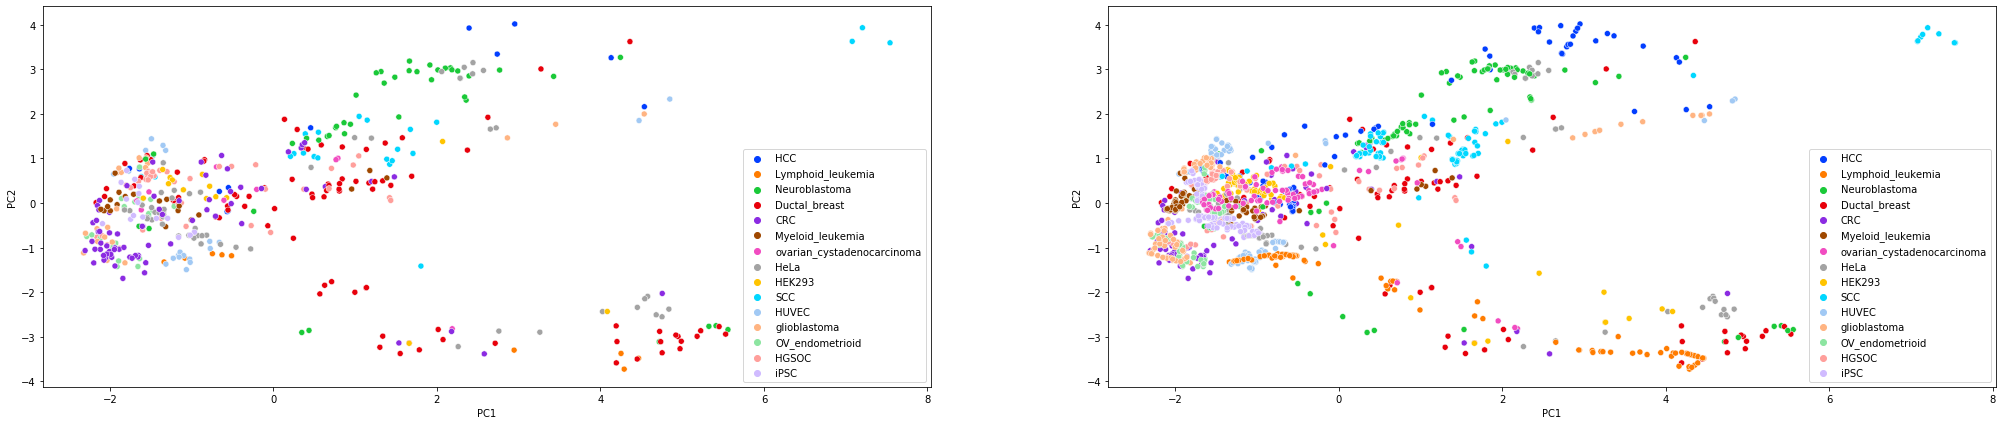

In [57]:
# oversample with smotetomek and check generated samples
oversampler = SMOTETomek()
X_tomek, y_tomek = oversampler.fit_resample(X_train_prep, Y_train)

pca = PCA(n_components=2)

pca.fit(X_train_prep)
embedding_original = pca.transform(X_train_prep)
embedding_sampled = pca.transform(X_tomek)

fig, ax = plt.subplots(1,2, figsize = (35,7))

sns.scatterplot(data=pd.DataFrame(embedding_original, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", hue = target_encoder.inverse_transform(Y_train), palette = colors, ax=ax[0])
sns.scatterplot(data=pd.DataFrame(embedding_sampled, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", hue = target_encoder.inverse_transform(y_tomek), palette = colors, ax=ax[1])

In [4]:
preprocessor_bio = Pipeline(steps=[
    ('filtering', FilterByClass(keep=True, percentage=.7)),
    ('imputer', LowestValueImputer()),
    ('scaler', MinMaxScaler())
])

X_train, X_test, y_train, y_test = train_test_split(data, targets,
                                                    stratify=targets, 
                                                    test_size=0.15)

preprocessor_bio.fit(X_train, y_train)
X_train_processed = preprocessor_bio.transform(X_train)
X_test_processed = preprocessor_bio.transform(X_test)

X_train_oversampled, y_oversampled = SMOTETomek().fit_resample(X_train_processed, y_train)

model_bio_lr = LogisticRegression(max_iter=10000)
model_bio_svc = SVC(probability=True)
model_bio_rf = RandomForestClassifier()

model_bio_lr.fit(X_train_oversampled, y_oversampled)
model_bio_svc.fit(X_train_oversampled, y_oversampled)
model_bio_rf.fit(X_train_oversampled, y_oversampled)

Y_pred_lr = model_bio_lr.predict(X_test_processed)
Y_pred_svc = model_bio_svc.predict(X_test_processed)
Y_pred_rf = model_bio_rf.predict(X_test_processed)

print("Score LR:  ", f1_score(y_test, Y_pred_lr, labels=unique_labels, average='micro'))
print("Score SVC: ", f1_score(y_test, Y_pred_svc, labels=unique_labels, average='micro'))
print("Score RF:  ", f1_score(y_test, Y_pred_rf, labels=unique_labels, average='micro'))

Score LR:   0.7307692307692306
Score SVC:  0.6538461538461539
Score RF:   0.6666666666666666


In [5]:
preprocessor_glob = Pipeline(steps=[
    ('filtering', FilterByOccurence(.7)),
    ('imputer', LowestValueImputer()),
    ('scaler', MinMaxScaler())
])

model_glob_lr = LogisticRegression(max_iter=10000)
model_glob_svc = SVC(probability=True)
model_glob_rf = RandomForestClassifier()

preprocessor_glob.fit(X_train, y_train)
X_train_processed_glob = preprocessor_glob.transform(X_train)
X_test_processed_glob = preprocessor_glob.transform(X_test)

X_train_oversampled_glob, y_oversampled_glob = SMOTETomek().fit_resample(X_train_processed_glob, y_train)

X_train_oversampled_glob = pd.DataFrame(X_train_oversampled_glob, columns= preprocessor_glob.named_steps.filtering.filtered_proteins)
X_train_processed_glob = pd.DataFrame(X_train_processed_glob, columns= preprocessor_glob.named_steps.filtering.filtered_proteins)
X_test_processed_glob = pd.DataFrame(X_test_processed_glob, columns= preprocessor_glob.named_steps.filtering.filtered_proteins)

model_glob_lr.fit(X_train_oversampled_glob, y_oversampled_glob)
model_glob_svc.fit(X_train_oversampled_glob, y_oversampled_glob)
model_glob_rf.fit(X_train_oversampled_glob, y_oversampled_glob)

Y_pred_glob_lr = model_glob_lr.predict(X_test_processed_glob)
Y_pred_glob_svc = model_glob_svc.predict(X_test_processed_glob)
Y_pred_glob_rf = model_glob_rf.predict(X_test_processed_glob)

print("Score LR:  ", f1_score(y_test, Y_pred_glob_lr, labels=unique_labels, average='micro'))
print("Score SVC: ", f1_score(y_test, Y_pred_glob_svc, labels=unique_labels, average='micro'))
print("Score RF:  ", f1_score(y_test, Y_pred_glob_rf, labels=unique_labels, average='micro'))

Score LR:   0.782051282051282
Score SVC:  0.7692307692307693
Score RF:   0.7564102564102565


In [5]:
bio_proteins = preprocessor_bio.named_steps.filtering.filtered_proteins
glob_proteins = preprocessor_glob.named_steps.filtering.filtered_proteins

NameError: name 'preprocessor_glob' is not defined

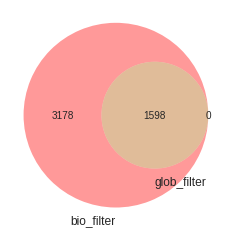

In [7]:
plt.figure(facecolor='white')
venn.venn2([set(bio_proteins), set(glob_proteins)], ("bio_filter", "glob_filter"))

In [8]:
shap_features_bio = list(preprocessor_bio.named_steps.filtering.filtered_proteins)
shap_features_glob = list(preprocessor_glob.named_steps.filtering.filtered_proteins)

In [9]:
train_targets = pd.DataFrame(data=y_train, columns = ["Encoding"])
train_targets["Label_name"] = train_targets.apply(lambda x: target_encoder.inverse_transform(x))

How are the test samples predicted?

In [10]:
predictions_lr = pd.DataFrame({'prediction': target_encoder.inverse_transform(Y_pred_lr), 'label': target_encoder.inverse_transform(y_test)})
predictions_lr["correct"] = predictions_lr.apply(lambda x: True if x["prediction"] == x["label"] else False, axis=1)

proba_predictions_lr = model_bio_lr.predict_proba(X_test_processed)
predictions_lr = pd.concat([predictions_lr, pd.DataFrame(proba_predictions_lr, columns = ['proba_'+x for x in target_encoder.inverse_transform(model_bio_lr.classes_)])], axis = 1)



predictions_svc = pd.DataFrame({'prediction': target_encoder.inverse_transform(Y_pred_svc), 'label': target_encoder.inverse_transform(y_test)})
predictions_svc["correct"] = predictions_svc.apply(lambda x: True if x["prediction"] == x["label"] else False, axis=1)

proba_predictions_svc = model_bio_svc.predict_proba(X_test_processed)
predictions_svc = pd.concat([predictions_svc, pd.DataFrame(proba_predictions_svc, columns = ['proba_'+x for x in target_encoder.inverse_transform(model_bio_svc.classes_)])], axis = 1)



predictions_rf = pd.DataFrame({'prediction': target_encoder.inverse_transform(Y_pred_rf), 'label': target_encoder.inverse_transform(y_test)})
predictions_rf["correct"] = predictions_rf.apply(lambda x: True if x["prediction"] == x["label"] else False, axis=1)

proba_predictions_rf = model_bio_rf.predict_proba(X_test_processed)
predictions_rf = pd.concat([predictions_rf, pd.DataFrame(proba_predictions_rf, columns = ['proba_'+x for x in target_encoder.inverse_transform(model_bio_rf.classes_)])], axis = 1)

Text(252.5, 0.5, 'True label')

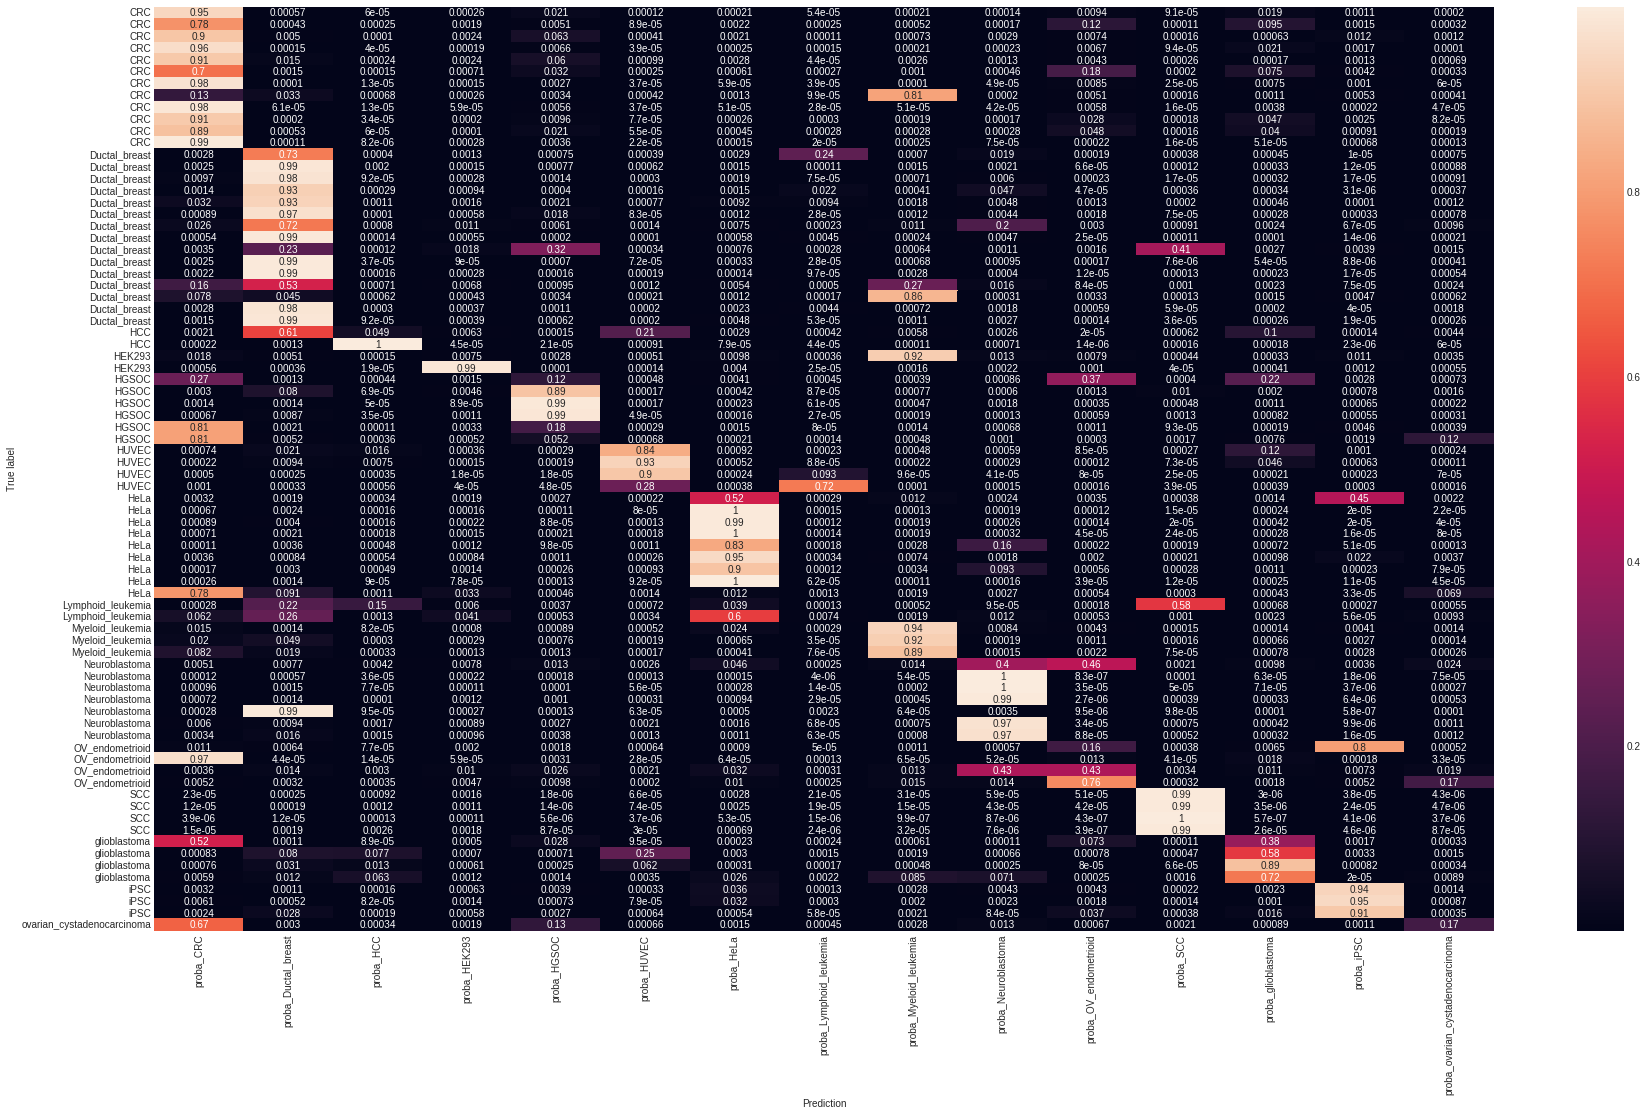

In [11]:
fig = plt.figure(figsize=(30,17))

s = sns.heatmap(predictions_lr.set_index('label').sort_index().iloc[:,2:], annot = True)
s.set_xlabel('Prediction')
s.set_ylabel('True label')

Text(252.5, 0.5, 'True label')

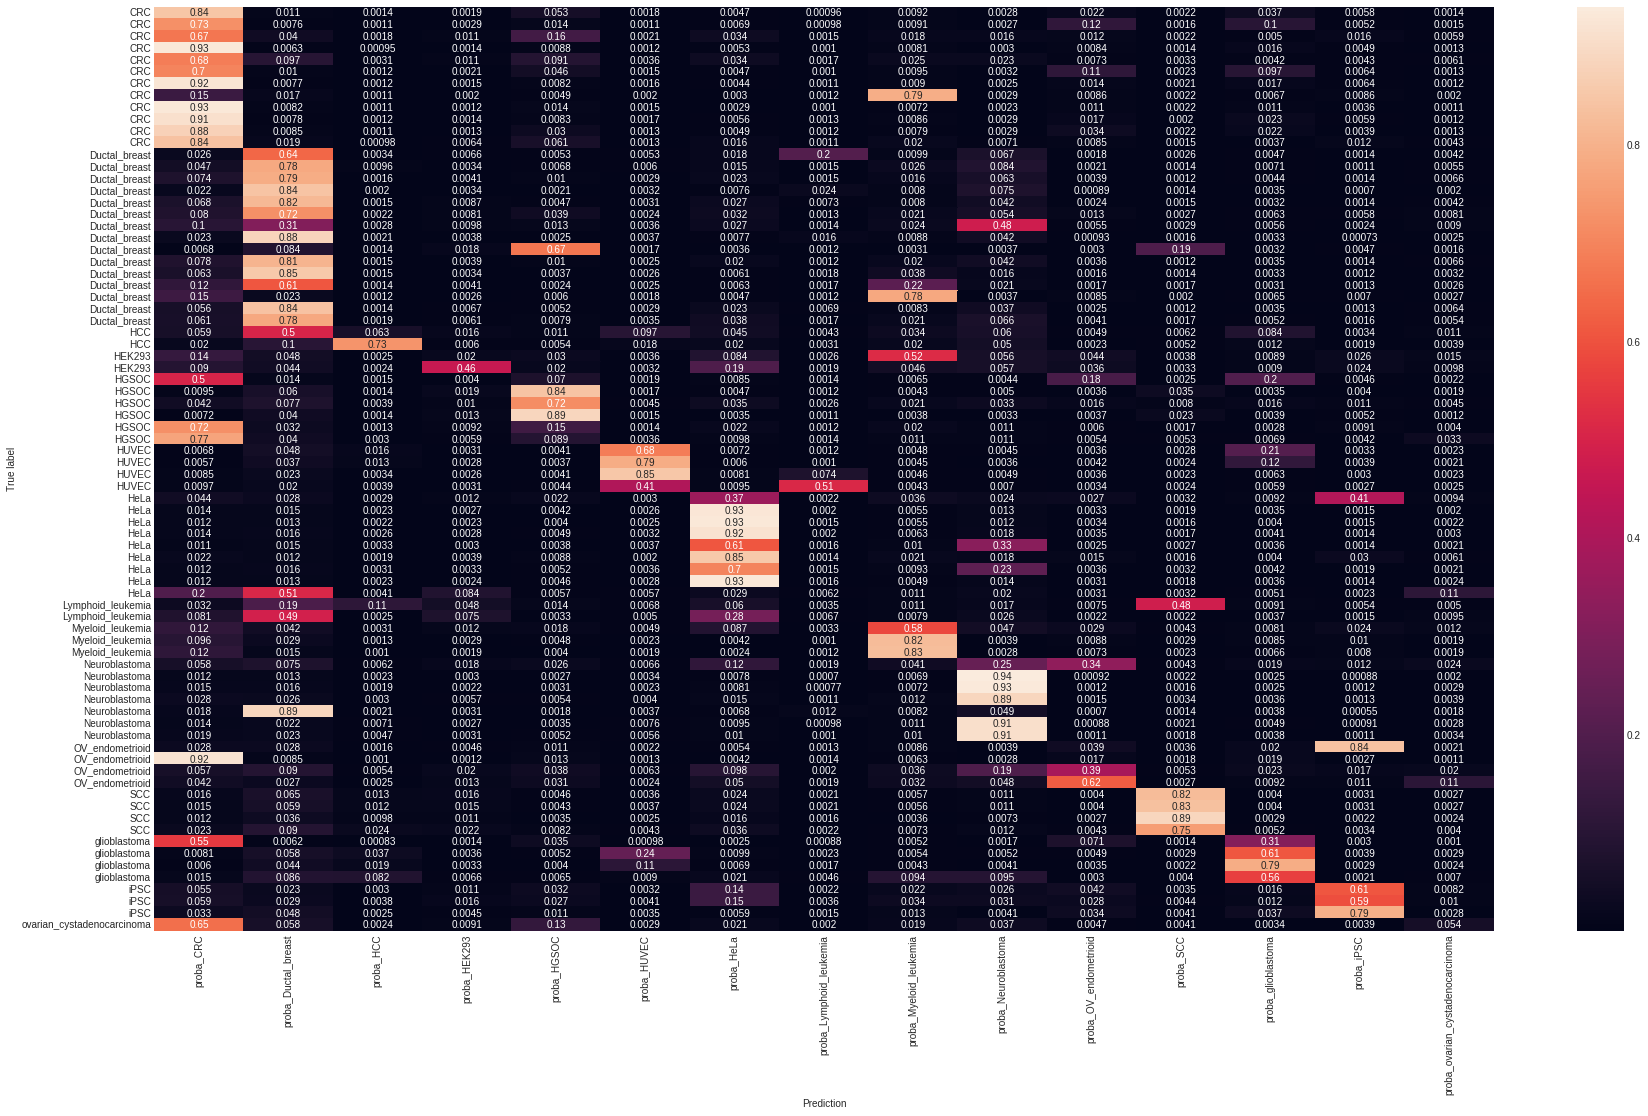

In [12]:
fig = plt.figure(figsize=(30,17))

s = sns.heatmap(predictions_svc.set_index('label').sort_index().iloc[:,2:], annot = True)
s.set_xlabel('Prediction')
s.set_ylabel('True label')

Text(252.5, 0.5, 'True label')

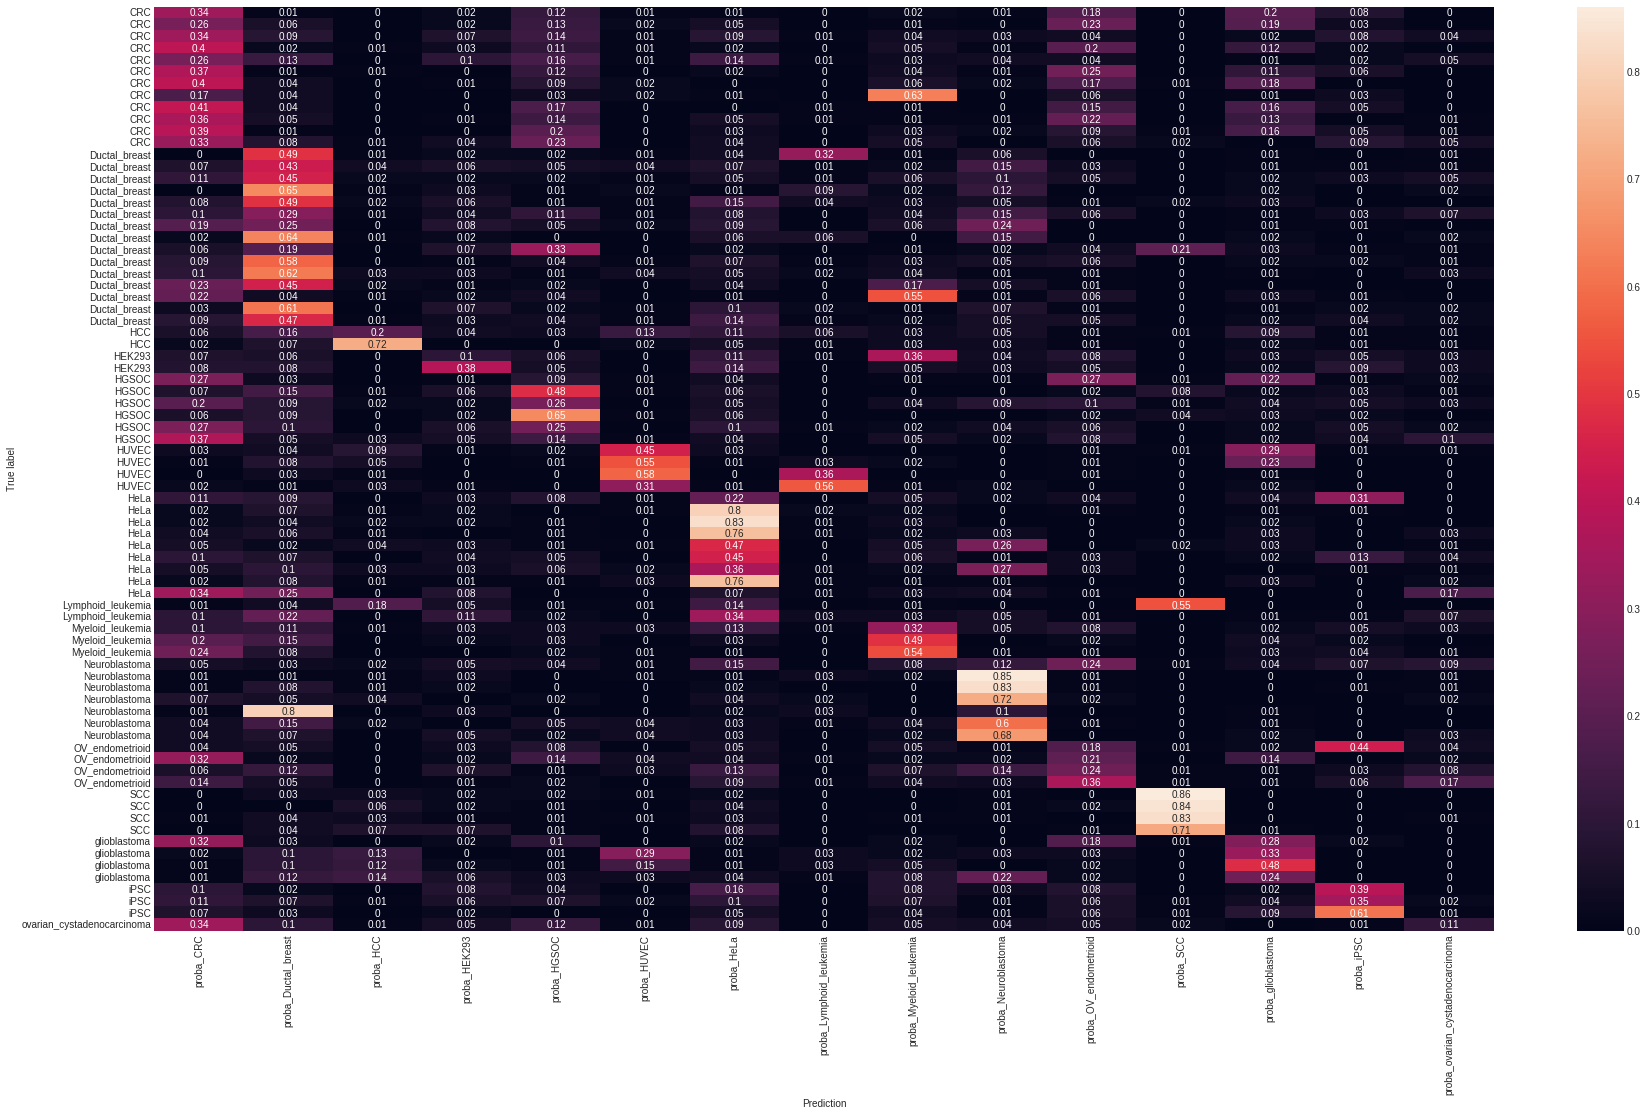

In [13]:
fig = plt.figure(figsize=(30,17))

s = sns.heatmap(predictions_rf.set_index('label').sort_index().iloc[:,2:], annot = True)
s.set_xlabel('Prediction')
s.set_ylabel('True label')

In [68]:
explainer_bio_lr = shap.LinearExplainer(model_bio_lr, X_train_oversampled)
shap_values_bio_lr = explainer_bio_lr.shap_values(X_test_processed)
shap_values_bio_lr_train = explainer_bio_lr.shap_values(X_train_processed)
print("LR explained")

#explainer_bio_svc = shap.KernelExplainer(model_bio_svc, shap.sample(X_train_oversampled, 30))
#shap_values_bio_svc = explainer_bio_svc.shap_values(X_test_processed)
#print("SVC explained")

explainer_bio_rf = shap.TreeExplainer(model_bio_rf)
shap_values_bio_rf = explainer_bio_rf.shap_values(X_test_processed)
shap_values_bio_rf_train = explainer_bio_rf.shap_values(X_train_processed)
print("RF explained")

LR explained
RF explained


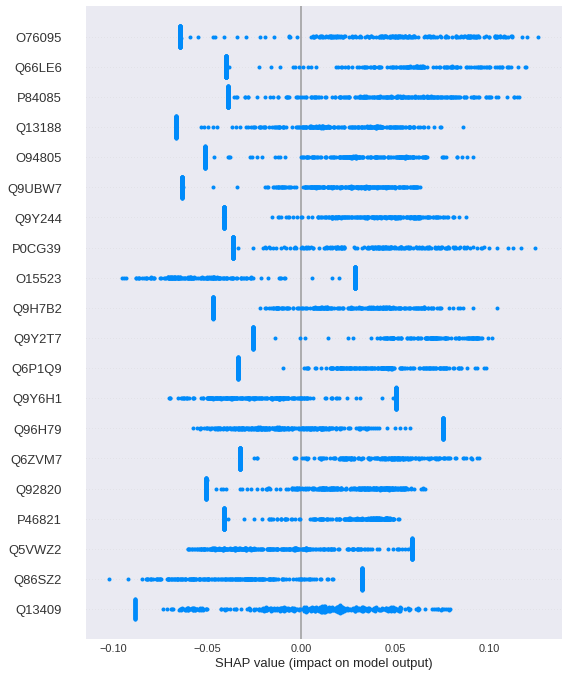

In [69]:
shap.summary_plot(shap_values_bio_lr_train[0], feature_names = shap_features_bio)

In [23]:
target_encoder.inverse_transform(model_bio_lr.classes_)

array(['CRC', 'Ductal_breast', 'HCC', 'HEK293', 'HGSOC', 'HUVEC', 'HeLa',
       'Lymphoid_leukemia', 'Myeloid_leukemia', 'Neuroblastoma',
       'OV_endometrioid', 'SCC', 'glioblastoma', 'iPSC',
       'ovarian_cystadenocarcinoma'], dtype=object)

In [70]:
y_train_df = pd.Series(y_train)

How is the size of the shap values distributed for each class. SHAP values show how much a single feature (protein) affects the prediction. Positive: for predicting that class; Negative: for not predicting that class

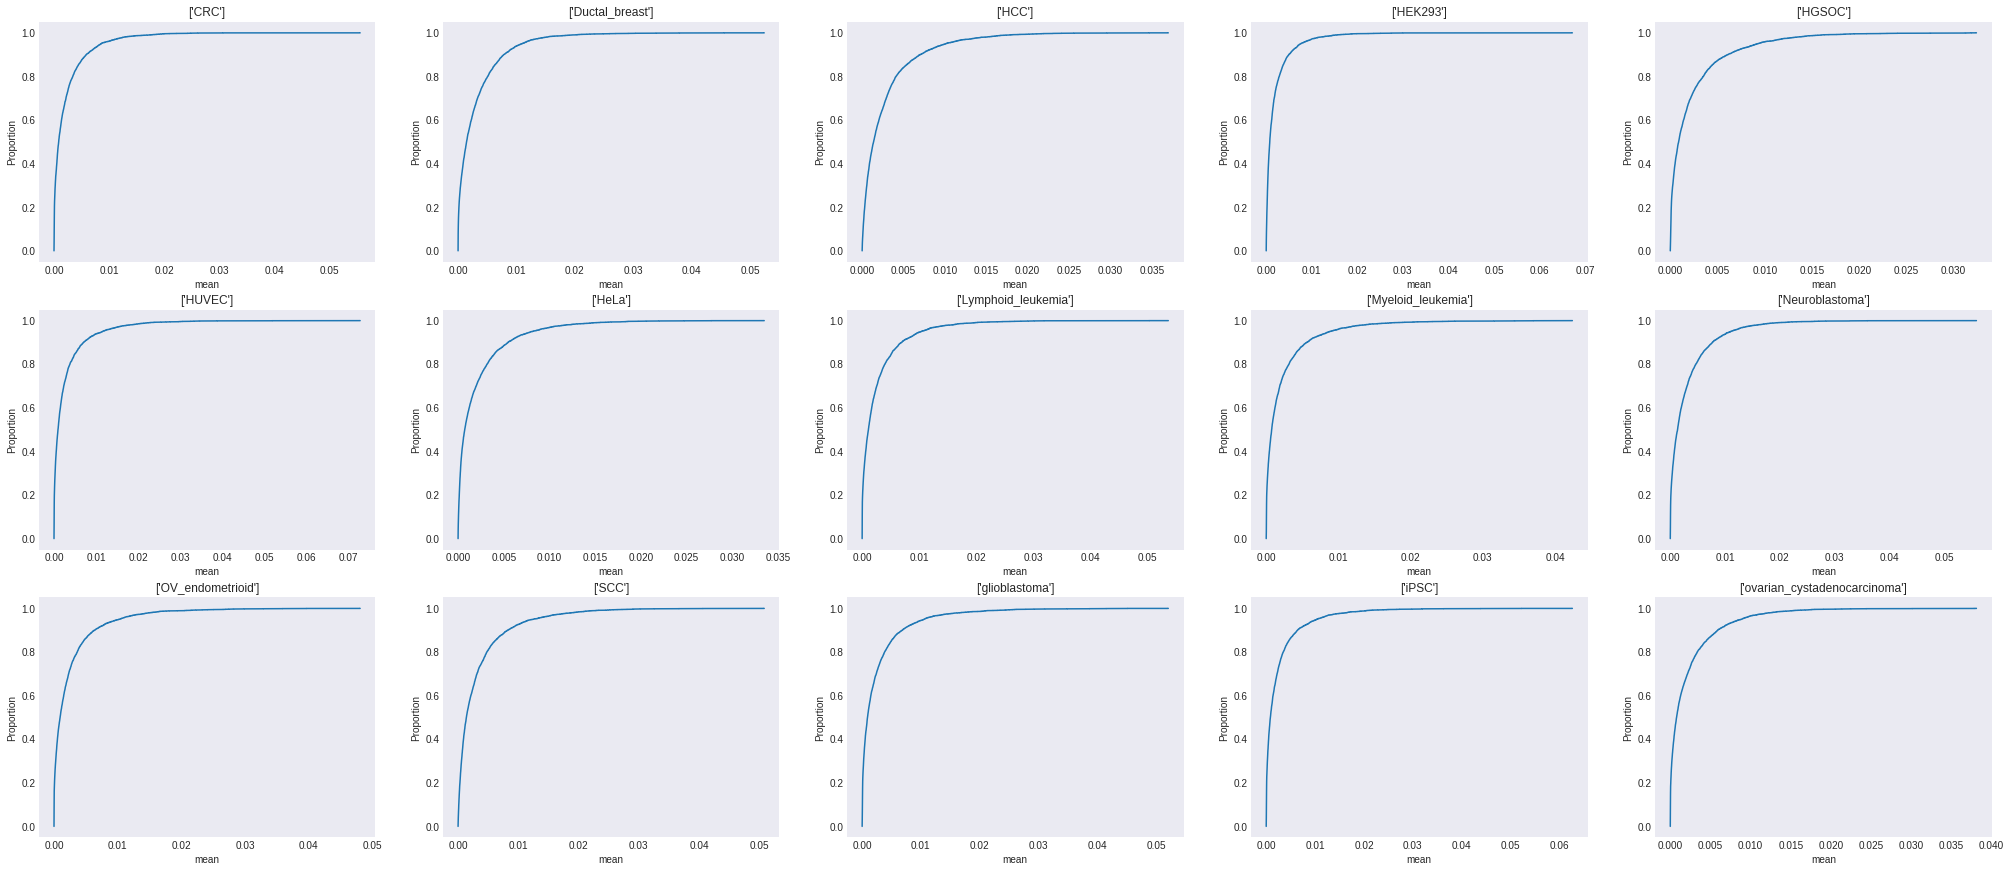

In [77]:
fig, ax = plt.subplots(3,5, figsize=(35,15))

y_axis = 0
x_axis = 0
for i in range(15):
    
    # Get the table of shap values for class i
    shaps_df = pd.DataFrame(shap_values_bio_lr_train[i], columns=shap_features_bio)

    # Create dataframe with mean and std of the shap values for the test_samples corresponding to that class 
    stat_shaps_df = pd.DataFrame(shaps_df.loc[y_train_df == i,:].mean(), columns = ["mean"])
    stat_shaps_df["std"] = shaps_df.loc[y_train_df == i,:].std()

    # Create cumulative distribution plot of the mean shap value of the proteins to see whether a few proteins have large shap value means for each class
    # This enables to inituitively select top % features based on their shap values
    ax[x_axis][y_axis].set_title(target_encoder.inverse_transform([i]))
    sns.ecdfplot(abs(stat_shaps_df['mean']), ax=ax[x_axis][y_axis])

    y_axis += 1
    if y_axis == 5:
        y_axis=0
        x_axis+=1

In [93]:
top_features = {}
for i in range(15):
    
    # Get the table of shap values for class i
    shaps_df = pd.DataFrame(shap_values_bio_lr_train[i], columns=shap_features_bio)

    # Create dataframe with mean of the shap values for the test_samples corresponding to the 
    stat_shaps_df = pd.DataFrame(shaps_df.loc[y_train_df == i,:].mean(), columns = ["mean"])

    # Extract protein ids with > .01 shap
    top_proteins = stat_shaps_df[stat_shaps_df["mean"] > .01].index.tolist()
    top_features[target_encoder.inverse_transform([i])[0]] = top_proteins

What are these proteins for each class?

In [98]:
for label, proteins in top_features.items():
    print("{}: {}".format(label, len(proteins)))

with open("top_features_lr.json", "w") as f:
    f.write(json.dumps(top_features))

CRC: 182
Ductal_breast: 262
HCC: 247
HEK293: 136
HGSOC: 198
HUVEC: 285
HeLa: 150
Lymphoid_leukemia: 254
Myeloid_leukemia: 188
Neuroblastoma: 285
OV_endometrioid: 246
SCC: 347
glioblastoma: 257
iPSC: 256
ovarian_cystadenocarcinoma: 164


In [71]:
target_encoder.inverse_transform([7])

array(['Lymphoid_leukemia'], dtype=object)

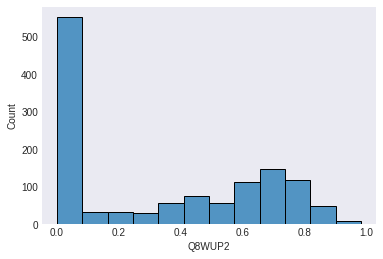

In [39]:
sns.histplot(pd.DataFrame(X_train_oversampled, columns = shap_features_bio).loc[:,"Q8WUP2"])

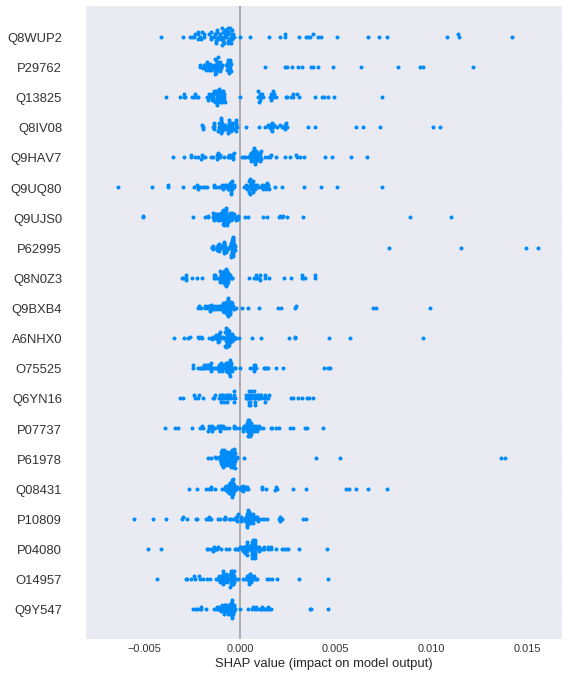

In [31]:
shap.summary_plot(shap_values_bio_rf[8], feature_names = shap_features_bio)

In [68]:
target_encoder.inverse_transform([9])

array(['Neuroblastoma'], dtype=object)

In [55]:
model_bio_rf.classes_

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [69]:
abs(pd.DataFrame(shap_values_bio_rf[9], columns = shap_features_bio).loc[:,:].mean()).sort_values()

P07237    0.000000
Q8IXB1    0.000000
O43175    0.000000
P51798    0.000000
Q9Y385    0.000000
            ...   
P49454    0.000534
Q9UPR3    0.000543
Q9Y478    0.000678
Q5VSL9    0.000736
Q9H9A6    0.000786
Length: 3999, dtype: float64

In [60]:
pd.DataFrame(shap_values_bio_rf[8], columns = shap_features_bio).loc[0,:][abs(pd.DataFrame(shap_values_bio_rf[8], columns = shap_features_bio).loc[:,:].mean())>.001]

Series([], Name: 0, dtype: float64)

In [149]:
train_targets[train_targets.Label_name == "SCC"].drop_duplicates()

,Encoding,Label_name
10,11,SCC


In [146]:
shap.Explanation(shap_obj_test[:,:,1], shap_obj_test.base_values[:,1], X_test_processed, feature_names=shap_feature_names)[2]

.values =
array([-0.00043824,  0.00305107,  0.00198204, ..., -0.00044705,
       -0.00317392,  0.00429982])

.base_values =
1.5758933890983549

.data =
array([0.38372185, 0.        , 0.80125976, ..., 0.        , 0.35316574,
       0.        ])

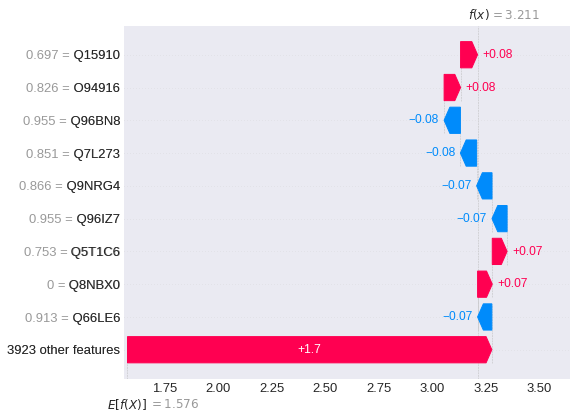

In [151]:
shap.waterfall_plot(shap_values= shap.Explanation(shap_obj_test[:,:,1], shap_obj_test.base_values[:,1], X_test_processed, feature_names=shap_feature_names)[2])

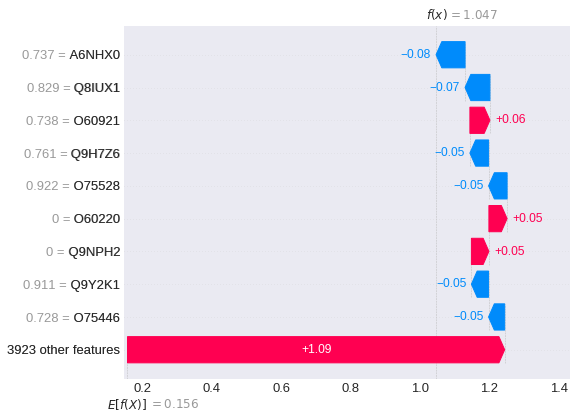

In [154]:
shap.waterfall_plot(shap_values= shap.Explanation(shap_obj_test[:,:,3], shap_obj_test.base_values[:,3], X_test_processed, feature_names=shap_feature_names)[2])

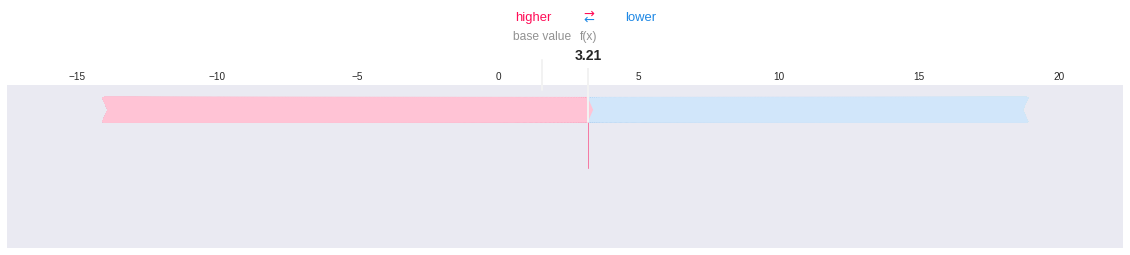

In [118]:
shap.force_plot(explainer.expected_value[1], shap_values_test[1][2], X_test_processed[2], feature_names = shap_feature_names, matplotlib=True)

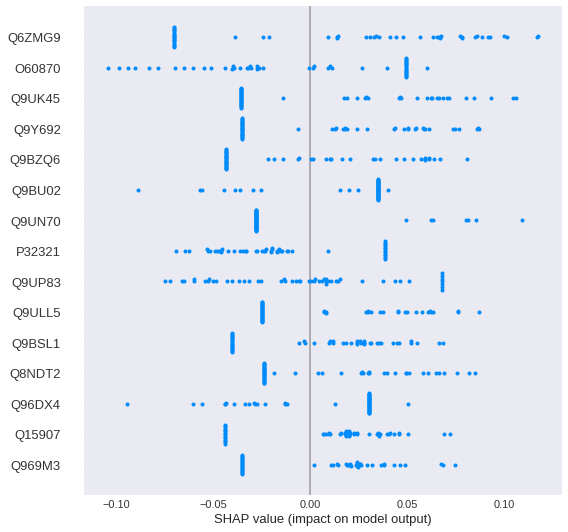

In [86]:
shap.summary_plot(shap_values_test[5], max_display=15, feature_names=shap_feature_names)

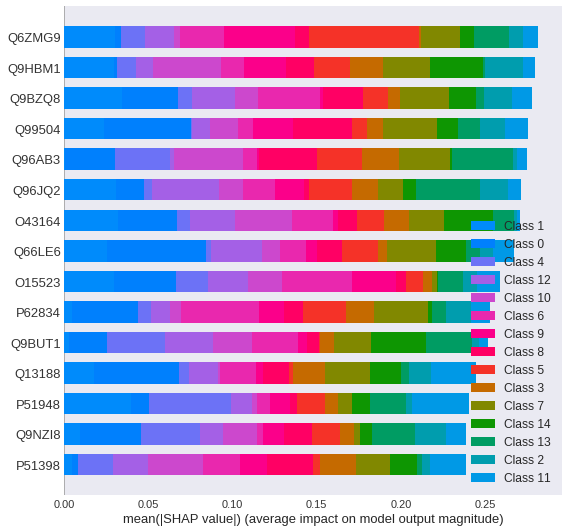

In [24]:
shap.summary_plot(shap_values_train, max_display=15, feature_names=shap_feature_names)

Plot importance per class

In [135]:
indices_neuro = train_targets[train_targets.Label_name == 'Neuroblastoma'].index
train_targets[train_targets.Label_name == 'Neuroblastoma'].head()

,Encoding,Label_name
0,9,Neuroblastoma
6,9,Neuroblastoma
10,9,Neuroblastoma
41,9,Neuroblastoma
43,9,Neuroblastoma


In [64]:
shap_neuroblastoma = shap_values_train[9][indices_neuro]

In [90]:
len(shap_obj[0][0])

15